<a href="https://colab.research.google.com/github/mspsullivan/poisonml/blob/main/poisoning_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Poisonml 
# Training Data poisoning attack.
# This notebook implements sleeper agent attack

In this notebook, we will learn how to use ART to run a Hidden Trigger Backdoor Attack Sleeper Agent poisoning attack on a neural network trained with Pytorch. We will be training our data on a subset of the CIFAR-10 dataset. The methods described are derived from [this paper](https://arxiv.org/pdf/2106.08970.pdf) by Hossein Souri, et. al. 2021.

#Initialization 1

In [2]:
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 54.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.1
    Uninstalling scikit-learn-1.2.1:
      Successfully uninstalled scikit-learn-1.2.1


#Initialization 2

In [3]:
import math
from tqdm import trange
import numpy as np
import os, sys
import pdb
from PIL import Image
from numpy import asarray
from skimage.transform import resize
import random
from art.estimators.classification import PyTorchClassifier
from art.utils import load_cifar10
from torchvision.models.resnet import BasicBlock, Bottleneck
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torch.nn.functional as F

#Initialization 3

In [4]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Model engineering 1
## Substitute Model Training 

In [5]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))

patch_size = 8
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#import urllib.request
#from PIL import Image
  
#urllib.request.urlretrieve('https://github.com/mspsullivan/poisonml/trigger_10.png')

img = Image.open('trigger_10.png')
#img = Image.open('https://raw.githubusercontent.com/mspsullivan/poisonml/main/trigger_10.png')
#img = Image.open('https://github.com/mspsullivan/poisonml/trigger_10.png') 
numpydata = asarray(img)
patch = resize(numpydata, (patch_size,patch_size,3))
patch = np.transpose(patch,(2,0,1))
x_train_orig = np.copy(x_train)

# Model engineering 2

In [6]:
num_classes = 10
loss_fn = nn.CrossEntropyLoss()
model = torchvision.models.ResNet(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
model_art = PyTorchClassifier(model,input_shape=x_train.shape[1:], loss=loss_fn, optimizer=optimizer, nb_classes=10, clip_values=(min_, max_), preprocessing=(mean,std))
model_art.fit(x_train, y_train, batch_size=128, nb_epochs=80,verbose=0)
predictions = model_art.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 74.97%


# Model engineering 3
## Define Source and Target Class

In [7]:
class_source = 0
class_target = 1
K = 1000

# Data engineering 1
## Select Triggers from Source Class and helper functions for calculating Success Rate

In [8]:
from art.utils import to_categorical
from art.attacks.poisoning.sleeper_agent_attack import SleeperAgentAttack

def select_trigger_train(x_train,y_train,K,class_source,class_target):
    x_train_ = np.copy(x_train)
    index_source = np.where(y_train.argmax(axis=1)==class_source)[0][0:K]
    index_target = np.where(y_train.argmax(axis=1)==class_target)[0]
    x_trigger = x_train_[index_source]
    y_trigger  = to_categorical([class_target], nb_classes=10)
    y_trigger = np.tile(y_trigger,(len(index_source),1))
    return x_trigger,y_trigger,index_target
   

# Data Engineering 2
## Generate Poison Images through attack 

In [9]:
x_trigger,y_trigger,index_target = select_trigger_train(x_train,y_train,K,class_source,class_target)
attack = SleeperAgentAttack(model_art,
                                percent_poison=0.50,
                                max_trials=1,
                                max_epochs=500,
                                learning_rate_schedule=(np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5]), [250, 350, 400, 430, 460]),
                                epsilon=16/255,
                                batch_size=500,
                                verbose=1,
                                indices_target=index_target,
                                patching_strategy="random",
                                selection_strategy="max-norm",
                                patch=patch,
                                retraining_factor = 4,
                                model_retrain = True,
                                model_retraining_epoch = 80,
                                retrain_batch_size = 128,
                                class_source = class_source,
                                class_target = class_target,
                                device_name = str(device)       
                           )
x_poison, y_poison = attack.poison(x_trigger,y_trigger,x_train,y_train,x_test,y_test) 
indices_poison = attack.get_poison_indices()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

# Data engineering 3
## Check indices selected for poisoning

In [10]:
indices_poison.sort()
indices_poison

array([   0,    3,    5, ..., 4991, 4993, 4999])

#Model engineering 4
## Train Victim Model with poisoned images

In [11]:
loss_fn = nn.CrossEntropyLoss()
model = torchvision.models.ResNet(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
model_poisoned = PyTorchClassifier(model,input_shape=x_train.shape[1:], loss=loss_fn, 
                                   optimizer=optimizer, nb_classes=10, clip_values=(min_, max_), 
                                   preprocessing=(mean,std))
model_poisoned.fit(x_poison, y_poison, batch_size=128, nb_epochs=150,verbose=0)
predictions = model_poisoned.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 74.67%


# Model engineering 5
## Visualize Trigger, Original and Poisoned Images 

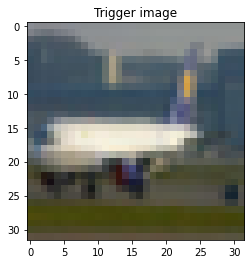

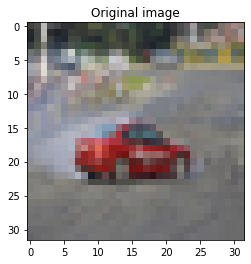

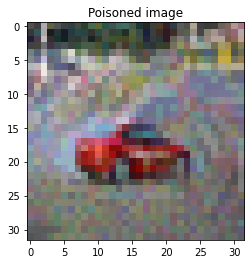

In [12]:
import matplotlib.pyplot as plt
plt.imshow(np.transpose(x_trigger[5],(1,2,0)))
plt.title('Trigger image')
plt.show()

index_poisoned_example = np.where([np.any(p!=o) for (p,o) in zip(x_poison,x_train)])[0]
plt.imshow(np.transpose(x_train_orig[index_target[indices_poison][5]],(1,2,0)))
plt.title('Original image')
plt.show()

plt.imshow(np.transpose(x_poison[index_target[indices_poison][5]],(1,2,0)))
plt.title('Poisoned image')
plt.show()

# Model engineering 6
## Calculate Success Rate on x_train and x_test

In [13]:
def add_trigger_patch(x_set,patch_type="fixed"):
    print(x_set.shape)
    img = Image.open('trigger_10.png')
    numpydata = asarray(img)
    print("shape of numpydata",numpydata.shape)
    patch = resize(numpydata, (patch_size,patch_size,3))
    patch = np.transpose(patch,(2,0,1))
    print("shape of patch",patch.shape)
    if patch_type == "fixed":
        x_set[:,:,-patch_size:,-patch_size:] = patch
    else:
        for x in x_set:
            x_cord = random.randrange(0,x.shape[1] - patch.shape[1] + 1)
            y_cord = random.randrange(0,x.shape[2] - patch.shape[2] + 1)
            x[:,x_cord:x_cord+patch_size,y_cord:y_cord+patch_size]=patch

    return x_set

# Model engineering 7
## Calculate on train images

(5000, 3, 32, 32)
shape of numpydata (80, 80, 3)
shape of patch (3, 8, 8)
5000
Train Success Rate 0.5954


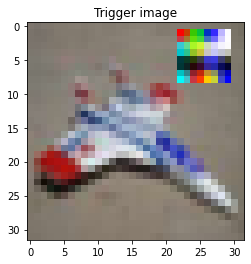

In [14]:
index_source_train = np.where(y_train.argmax(axis=1)==class_source)[0]
x_train_trigger = x_train_orig[index_source_train]
x_train_trigger = add_trigger_patch(x_train_trigger,"random")
result_poisoned_train = model_poisoned.predict(x_train_trigger)
print(len(result_poisoned_train))

success_train = (np.argmax(result_poisoned_train,axis=1)==1).sum()/result_poisoned_train.shape[0]
print("Train Success Rate",success_train)
plt.imshow(np.transpose(x_train_trigger[1],(1,2,0)))
plt.title('Trigger image')
plt.show()

# Model engineering 8
## Calculate Success Rate on Test 

(1000, 3, 32, 32)
shape of numpydata (80, 80, 3)
shape of patch (3, 8, 8)
1000
Test Success Rate: 0.616


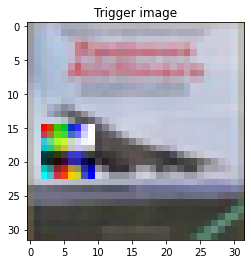

In [15]:
index_source_test = np.where(y_test.argmax(axis=1)==class_source)[0]
x_test_trigger = x_test[index_source_test]
x_test_trigger = add_trigger_patch(x_test_trigger,"random")
result_poisoned_test = model_poisoned.predict(x_test_trigger)
print(len(result_poisoned_test))

success_test = (np.argmax(result_poisoned_test,axis=1)==1).sum()/result_poisoned_test.shape[0]
print("Test Success Rate:",success_test)

plt.imshow(np.transpose(x_test_trigger[0],(1,2,0)))
plt.title('Trigger image')
plt.show()